In [1]:
import numpy as np
import pandas as pd
import re
import psutil
import time
from datetime import datetime
from memory_profiler import profile
import matplotlib.pyplot as plt

from nltk.corpus import stopwords
from vaderSentiment import SentimentIntensityAnalyzer

from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

## Data Prep

In [2]:
# read csv and put into dataframe
df = pd.read_csv("amazon_reviews_3k.csv", encoding="UTF-8", nrows=1500)
df

,asin,name,date,rating,review
0,B07W7CTLD1,Mamaearth-Onion-Growth-Control-Redensyl,2019-09-06,1,I bought this hair oil after viewing so many g...
1,B07W7CTLD1,Mamaearth-Onion-Growth-Control-Redensyl,2019-08-14,5,Used This Mama Earth Newly Launched Onion Oil ...
2,B07W7CTLD1,Mamaearth-Onion-Growth-Control-Redensyl,2019-10-19,1,So bad product...My hair falling increase too ...
3,B07W7CTLD1,Mamaearth-Onion-Growth-Control-Redensyl,2019-09-16,1,Product just smells similar to navarathna hair...
4,B07W7CTLD1,Mamaearth-Onion-Growth-Control-Redensyl,2019-08-18,5,I have been trying different onion oil for my ...
...,...,...,...,...,...
1495,B01MQNBOLA,Cinthol-Cool-Soap-100g-Free,2020-06-18,1,"In television advertisement, the color of the ..."
1496,B01MQNBOLA,Cinthol-Cool-Soap-100g-Free,2020-09-04,4,Decent Soap. Very fresh and nice. Gives good a...
1497,B01MQNBOLA,Cinthol-Cool-Soap-100g-Free,2020-08-12,1,Has absolutely no perfume at all... and it is ...
1498,B01MQNBOLA,Cinthol-Cool-Soap-100g-Free,2020-08-02,1,This soap fluxes so fast even when you put it ...


## Cleaning data and Sentiment Analysis 

In [3]:
x_values = df['review'].values  

processed_reviews = []

# iterate through each review
for review in range(0, len(x_values)):
    # remove special characters
    processed_review = re.sub(r'\W', ' ', str(df['review'][review]))

    # remove single characters
    processed_review = re.sub(r'\s+[a-zA-Z]\s+', ' ', processed_review)
    processed_review = re.sub(r'\^[a-zA-Z]\s+', ' ', processed_review)

    # remove multiple spaces
    processed_review = re.sub(r'\s+', ' ', processed_review, flags=re.I)

    # remove prefixed 'b' (if applicable, assuming X is a list of strings)
    processed_review = re.sub(r'^b\s+', '', processed_review)

    # convert to lowercase
    processed_review = processed_review.lower()

    # append to the empty list created earlier
    processed_reviews.append(processed_review)

# put all processed reviews into new column 
df['processed_reviews'] = processed_reviews

In [4]:
# set stopwords
stopWords = set(stopwords.words('english') + ['the', 'a', 'an', 'i', 'he', 'she', 'they', 'to', 'of', 'it', 'from'])

def removeStopWords(stopWords, rvw_txt):
    newtxt = ' '.join([word for word in rvw_txt.split() if word.lower() not in stopWords])
    return newtxt


df['processed_reviews'] = df['processed_reviews'].astype(str)

# before stop words removed
print("Before removing stop words:")
print(df['processed_reviews'].head())

# apply removeStopWords function
df['clean_review_text'] = [removeStopWords(stopWords, x) for x in df['processed_reviews']]

# after stop words removed
print("\nAfter removing stop words:")
print(df['clean_review_text'].head())

Before removing stop words:
0    i bought this hair oil after viewing so many g...
1    used this mama earth newly launched onion oil ...
2    so bad product my hair falling increase too mu...
3    product just smells similar to navarathna hair...
4    i have been trying different onion oil for my ...
Name: processed_reviews, dtype: object

After removing stop words:
0    bought hair oil viewing many good comments pro...
1    used mama earth newly launched onion oil twice...
2    bad product hair falling increase much order s...
3    product smells similar navarathna hair oil str...
4    trying different onion oil hair hair healthy p...
Name: clean_review_text, dtype: object


In [5]:
sentiment_model = SentimentIntensityAnalyzer()
sentiment_scores=[]
sentiment_score_flag = []

# iterate over text and calculate sentiment
for text in df['clean_review_text']:
        sentimentResults = sentiment_model.polarity_scores(text)
        sentiment_score = sentimentResults["compound"]

        # append sentiment score and label
        sentiment_scores.append(sentiment_score)

        # marking the sentiments as positive, negative and neutral 
        if sentimentResults['compound'] >= 0.05 : 
            sentiment_score_flag.append('positive')
  
        elif sentimentResults['compound'] <= - 0.05 : 
            sentiment_score_flag.append('negative')
  
        else : 
            sentiment_score_flag.append('neutral')
            
# add into new column
df['scores'] = sentiment_scores
df['scoreStatus'] = sentiment_score_flag

## Tokenize and Generate Training Data

In [6]:
# tokenize text
def tokenize(text):
    # obtains tokens with a least 1 alphabet
    pattern = re.compile(r'[A-Za-z]+[\w^\']*|[\w^\']*[A-Za-z]+[\w^\']*')
    return pattern.findall(text.lower())

# create a mapping between words and their corresponding IDs
def mapping(tokens):
    word_to_id = dict()
    id_to_word = dict()

    for i, token in enumerate(set(tokens)):
        word_to_id[token] = i
        id_to_word[i] = token

    return word_to_id, id_to_word

# generate training data for a word embedding model using a skip-gram approach
def generate_training_data(tokens, word_to_id, window_size):
    N = len(tokens)
    X, Y = [], []

    for i in range(N):
        nbr_inds = list(range(max(0, i - window_size), i)) + \
                   list(range(i + 1, min(N, i + window_size + 1)))
        for j in nbr_inds:
            X.append(word_to_id[tokens[i]])
            Y.append(word_to_id[tokens[j]])
            
    X = np.array(X)
    X = np.expand_dims(X, axis=0)
    Y = np.array(Y)
    Y = np.expand_dims(Y, axis=0)
            
    return X, Y

In [7]:
df['clean_review_text'] = df['clean_review_text'].astype(str)
docs = df['clean_review_text'].tolist()

# tokenize each document separately
tokens = [tokenize(doc) for doc in docs]

# create word-to-id and id-to-word mappings from all tokens
word_to_id, id_to_word = mapping([token for sublist in tokens for token in sublist])

# generate training data from tokens
X, Y = generate_training_data([token for sublist in tokens for token in sublist], word_to_id, 3)

# vocabulary size
vocab_size = len(id_to_word)

# number of training samples
m = Y.shape[1]

# turn Y into one hot encoding
Y_one_hot = np.zeros((vocab_size, m))
Y_one_hot[Y.flatten(), np.arange(m)] = 1

## Initialization

In [8]:
# initialize the word embedding matrix
def initialize_wrd_emb(vocab_size, emb_size):
    """
    vocab_size: int. vocabulary size of your corpus or training data
    emb_size: int. word embedding size. How many dimensions to represent each vocabulary
    """
    WRD_EMB = np.random.randn(vocab_size, emb_size) * 0.01
    
    assert(WRD_EMB.shape == (vocab_size, emb_size))
    return WRD_EMB

# initialize the weight matrix for a dense layer
def initialize_dense(input_size, output_size):
    """
    input_size: int. size of the input to the dense layer
    output_szie: int. size of the output out of the dense layer
    """
    W = np.random.randn(output_size, input_size) * 0.01
    
    assert(W.shape == (output_size, input_size))
    return W

# initialize parameters for a neural network model
def initialize_parameters(vocab_size, emb_size):
    WRD_EMB = initialize_wrd_emb(vocab_size, emb_size)
    W = initialize_dense(emb_size, vocab_size)
    
    parameters = {}
    parameters['WRD_EMB'] = WRD_EMB
    parameters['W'] = W
    
    return parameters

## Forward Propagation

In [9]:
# convert word indices to word vectors
def ind_to_word_vecs(inds, parameters):
    """
    inds: numpy array. shape: (1, m)
    parameters: dict. weights to be trained
    """
    m = inds.shape[1]
    WRD_EMB = parameters['WRD_EMB']
    word_vec = WRD_EMB[inds.flatten(), :].T
    
    assert(word_vec.shape == (WRD_EMB.shape[1], m))
    
    return word_vec

# perform linear transformation with a dense layer
def linear_dense(word_vec, parameters):
    """
    word_vec: numpy array. shape: (emb_size, m)
    parameters: dict. weights to be trained
    """
    m = word_vec.shape[1]
    W = parameters['W']
    Z = np.dot(W, word_vec)
    
    assert(Z.shape == (W.shape[0], m))
    
    return W, Z

# apply softmax activation to the output
def softmax(Z):
    """
    Z: output out of the dense layer. shape: (vocab_size, m)
    """
    softmax_out = np.divide(np.exp(Z), np.sum(np.exp(Z), axis=0, keepdims=True) + 0.001)
    
    assert(softmax_out.shape == Z.shape)

    return softmax_out

# perform forward propagation through the neural network
def forward_propagation(inds, parameters):
    word_vec = ind_to_word_vecs(inds, parameters)
    W, Z = linear_dense(word_vec, parameters)
    softmax_out = softmax(Z)
    
    caches = {}
    caches['inds'] = inds
    caches['word_vec'] = word_vec
    caches['W'] = W
    caches['Z'] = Z
    
    return softmax_out, caches

## Cost Function

In [10]:
# compute the cross-entropy loss
def cross_entropy(softmax_out, Y):
    """
    softmax_out: output out of softmax. shape: (vocab_size, m)
    """
    m = softmax_out.shape[1]
    cost = -(1 / m) * np.sum(np.sum(Y * np.log(softmax_out + 0.001), axis=0, keepdims=True), axis=1)
    return cost

## Backward Propagation

In [11]:
# compute gradient of softmax activation
def softmax_backward(Y, softmax_out):
    """
    Y: labels of training data. shape: (vocab_size, m)
    softmax_out: output out of softmax. shape: (vocab_size, m)
    """
    dL_dZ = softmax_out - Y
    
    assert(dL_dZ.shape == softmax_out.shape)
    return dL_dZ

# compute gradient of the dense layer
def dense_backward(dL_dZ, caches):
    """
    dL_dZ: shape: (vocab_size, m)
    caches: dict. results from each steps of forward propagation
    """
    W = caches['W']
    word_vec = caches['word_vec']
    m = word_vec.shape[1]
    
    dL_dW = (1 / m) * np.dot(dL_dZ, word_vec.T)
    dL_dword_vec = np.dot(W.T, dL_dZ)

    assert(W.shape == dL_dW.shape)
    assert(word_vec.shape == dL_dword_vec.shape)
    
    return dL_dW, dL_dword_vec

# perform backward propagation to compute gradients
def backward_propagation(Y, softmax_out, caches):
    dL_dZ = softmax_backward(Y, softmax_out)
    dL_dW, dL_dword_vec = dense_backward(dL_dZ, caches)
    
    gradients = dict()
    gradients['dL_dZ'] = dL_dZ
    gradients['dL_dW'] = dL_dW
    gradients['dL_dword_vec'] = dL_dword_vec
    
    return gradients

# update the parameters using gradient descent
def update_parameters(parameters, caches, gradients, learning_rate):
    vocab_size, emb_size = parameters['WRD_EMB'].shape
    inds = caches['inds']
    dL_dword_vec = gradients['dL_dword_vec']
    m = inds.shape[-1]
    
    parameters['WRD_EMB'][inds.flatten(), :] -= dL_dword_vec.T * learning_rate

    parameters['W'] -= learning_rate * gradients['dL_dW']

In [12]:
# implement training for skip-gram word embedding model 
def skipgram_model_training(X, Y, vocab_size, emb_size, learning_rate, epochs, batch_size=256, parameters=None, print_cost=False, plot_cost=True):
    costs = []
    m = X.shape[1]
    
    if parameters is None:
        parameters = initialize_parameters(vocab_size, emb_size)
    
    begin_time = datetime.now()
    for epoch in range(epochs):
        epoch_cost = 0
        batch_inds = list(range(0, m, batch_size))
        np.random.shuffle(batch_inds)
        for i in batch_inds:
            X_batch = X[:, i:i+batch_size]
            Y_batch = Y[:, i:i+batch_size]

            softmax_out, caches = forward_propagation(X_batch, parameters)
            gradients = backward_propagation(Y_batch, softmax_out, caches)
            update_parameters(parameters, caches, gradients, learning_rate)
            cost = cross_entropy(softmax_out, Y_batch)
            epoch_cost += np.squeeze(cost)
            
        costs.append(epoch_cost)
    end_time = datetime.now()
    print('training time: {}'.format(end_time - begin_time))
            
    if plot_cost:
        plt.plot(np.arange(epochs), costs)
        plt.xlabel('# of epochs')
        plt.ylabel('cost')
    return parameters

training time: 0:26:07.298623


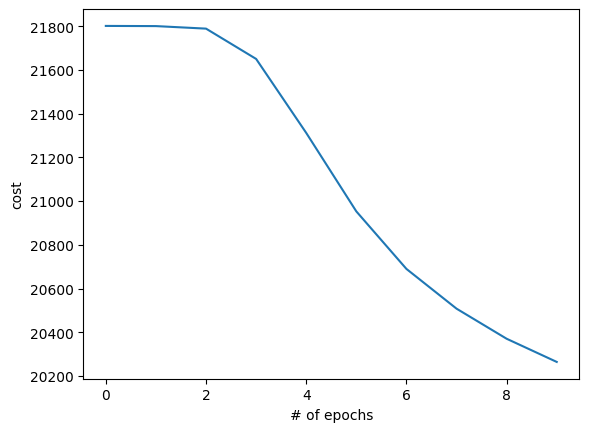

In [13]:
paras = skipgram_model_training(X, Y_one_hot, vocab_size, 50, 0.05, 10, batch_size=64, parameters=None)

ERROR: Could not find file /var/folders/k7/hgkz89px7jz91sbyc7lxqdxh0000gn/T/ipykernel_15597/3161904966.py
training time: 0:17:30.258683
Memory Usage: 1626.11 MB (Resident Set Size)
Virtual Memory: 405801.06 MB


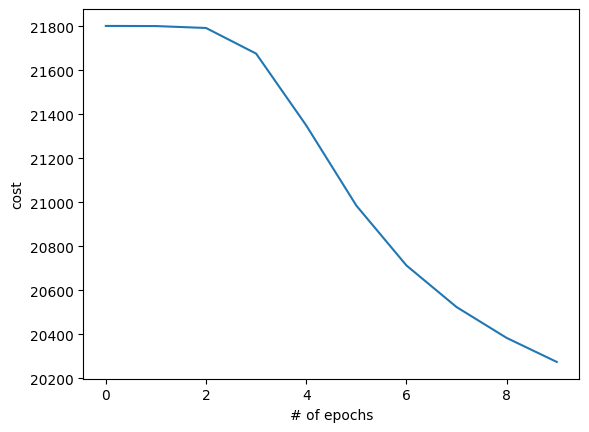

In [14]:
# check memory usage of applying TF-IDF to the data
def print_memory_usage():
    process = psutil.Process()
    memory_info = process.memory_info()

    print(f"Memory Usage: {memory_info.rss / (1024 ** 2):.2f} MB (Resident Set Size)")
    print(f"Virtual Memory: {memory_info.vms / (1024 ** 2):.2f} MB")

@profile
def train_skipgram_model_memory():
    paras = skipgram_model_training(X, Y_one_hot, vocab_size, 50, 0.05, 10, batch_size=64, parameters=None) 
    print_memory_usage()   

train_skipgram_model_memory()

## Obtain word embeddings for each word in the dataset

In [15]:
# generate word embeddings 
def get_word_embeddings(words, parameters):
    word_indices = [word_to_id[word] for word in words if word in word_to_id]
    word_indices = np.array(word_indices).astype(int)  # Convert to integers
    word_vecs = ind_to_word_vecs(word_indices.reshape(1, -1), parameters)
    return word_vecs

word_embeddings = get_word_embeddings(docs, paras)

## Aggregate Word Embeddings

In [16]:
# creates average sentence embeddings from tokenized texts
def aggregate_embeddings(tokenized_texts, parameters):
    sentence_embeddings = []
    placeholder_embedding = None

    for sentence in tokenized_texts:
        word_indices = [word_to_id[word] for word in sentence if word in word_to_id]
        word_indices = np.array(word_indices, dtype=np.int64)  # convert to integer type

        if len(word_indices) > 0:
            word_vecs = ind_to_word_vecs(word_indices.reshape(1, -1), parameters)
            avg_embedding = np.mean(word_vecs, axis=1)  # average word embeddings for the sentence
            sentence_embeddings.append(avg_embedding)
            placeholder_embedding = avg_embedding  # update the placeholder

        elif placeholder_embedding is not None:
            # append the placeholder for empty sentences
            sentence_embeddings.append(placeholder_embedding)

    return np.vstack(sentence_embeddings)

sentence_embeddings = aggregate_embeddings(tokens, paras)

## Train Sentiment Analysis Model

In [17]:
X_train = sentence_embeddings  # features
y_train = df["scoreStatus"]  # labels

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# initialize the classifier
clf = LinearSVC()

# train the classifier
clf.fit(X_train, y_train)

# make predictions on the test set
y_pred = clf.predict(X_test)

# calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy on test set: {accuracy}")

# calculate precision, recall, and F1-score
precision = precision_score(y_test, y_pred, average='micro')  # Choose the appropriate average setting
recall = recall_score(y_test, y_pred, average='micro')  # Choose the appropriate average setting
f1 = f1_score(y_test, y_pred, average='micro')  # Choose the appropriate average setting

print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1-Score: {f1}')

# Classification report
report = classification_report(y_test, y_pred, zero_division=0)
print("\n",report)

Accuracy on test set: 0.7833333333333333
Precision: 0.7833333333333333
Recall: 0.7833333333333333
F1-Score: 0.7833333333333333

               precision    recall  f1-score   support

    negative       1.00      0.07      0.12        45
     neutral       0.00      0.00      0.00        23
    positive       0.78      1.00      0.88       232

    accuracy                           0.78       300
   macro avg       0.59      0.36      0.33       300
weighted avg       0.75      0.78      0.70       300



/Users/priscillaabigail/Library/Python/3.9/lib/python/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


In [19]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# initialize the classifier
gnb = GaussianNB()

# train the classifier
gnb.fit(X_train, y_train)

# make predictions on the test set
y_pred = gnb.predict(X_test)

# calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy on test set: {accuracy}")

# classification report
report = classification_report(y_test, y_pred, zero_division=0)
print("\n", report)

Accuracy on test set: 0.5

               precision    recall  f1-score   support

    negative       0.22      0.70      0.33        37
     neutral       0.32      0.44      0.37        16
    positive       0.89      0.47      0.61       187

    accuracy                           0.50       240
   macro avg       0.47      0.54      0.44       240
weighted avg       0.75      0.50      0.55       240



In [20]:
start_time = time.time()

# Code for training your model
clf.fit(X_train, y_train)

end_time = time.time()
training_time = end_time - start_time
print(f"Training Time: {training_time} seconds")

/Users/priscillaabigail/Library/Python/3.9/lib/python/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Training Time: 0.08358120918273926 seconds


In [21]:
import sys
model_size = sys.getsizeof(clf)
print(f"Model Size: {model_size / (1024 * 1024)} MB")

Model Size: 4.57763671875e-05 MB


## Predict 

In [22]:
new_text = "this product was very bad"
tokenized_new_text = new_text.split()

new_text_word_indices = [word_to_id[word] for word in tokenized_new_text if word in word_to_id]
new_text_word_vecs = ind_to_word_vecs(np.array(new_text_word_indices).reshape(1, -1), paras)

avg_embedding_new_text = np.mean(new_text_word_vecs, axis=1)

predicted_sentiment = clf.predict(avg_embedding_new_text.reshape(1, -1))
print(f"Predicted sentiment: {predicted_sentiment}")

Predicted sentiment: ['negative']


In [23]:
new_text = "this product was very good"
tokenized_new_text = new_text.split()

new_text_word_indices = [word_to_id[word] for word in tokenized_new_text if word in word_to_id]
new_text_word_vecs = ind_to_word_vecs(np.array(new_text_word_indices).reshape(1, -1), paras)

avg_embedding_new_text = np.mean(new_text_word_vecs, axis=1)

predicted_sentiment = clf.predict(avg_embedding_new_text.reshape(1, -1))
print(f"Predicted sentiment: {predicted_sentiment}")

Predicted sentiment: ['positive']
